# Render DECA w/ cond_utils

Key=> shape : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-light-anno.txt
Key=> albedo : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-albedo-anno.txt
Key=> tform : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-tform-anno.txt
Key=> detail : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-detail-anno.txt
creating the FLAME Decoder
[#] DECA : SRenderY applied mask


100%|██████████| 37/37 [00:30<00:00,  1.20it/s]
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx2

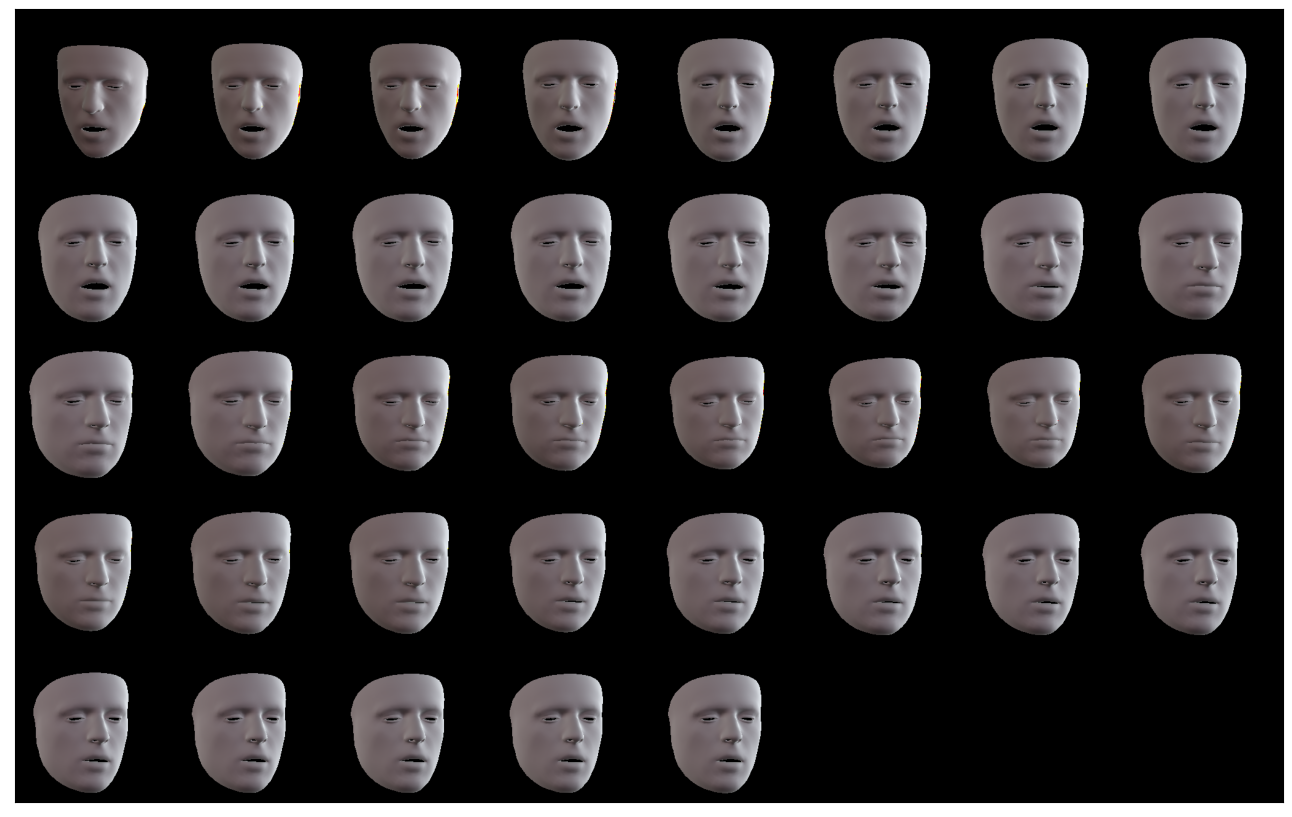

In [2]:
import numpy as np
import sys, os, glob
import blobfile as bf
from PIL import Image
import torch as th
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import tqdm


import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def save_images(images, names, save_path):
    for i, img in enumerate(images):
        save_image(img, fp=f'{save_path}/{names[i]}')
        

def load_image(path):
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    return pil_image

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/sample_utils/')
sys.path.insert(1, '/home/mint/guided-diffusion/guided_diffusion/dataloader/')

import params_utils
sj = 'tommy_2'
img_path = '/data/mint/DPM_Dataset/Videos/tommy_2/aligned_images/valid/'
#NOTE: Initialize a DECA renderer
params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'albedo', 'tform', 'detail']
deca_params, _ = params_utils.load_params(path=f'/data/mint/DPM_Dataset/Videos/{sj}/params/valid', params_key=params_key)

deca_arr = {}
frames = list(deca_params.keys())
chunk_size = 1
frames_chunks = []
deca_rendered = []
for i in range(0, len(frames), chunk_size):
    frames_chunks.append(frames[i:i+chunk_size])
    
mask = params_utils.load_flame_mask()
# deca_obj = params_utils.init_deca(mask=mask, useTex=True, extractTex=True, deca_mode='renderer')
# use_detail = True
deca_obj = params_utils.init_deca(mask=mask)
use_detail = False
for fc in tqdm.tqdm(frames_chunks):
    for k in params_key:
            deca_arr[k] = np.stack([deca_params[f][k] for f in fc])
            # print(k, deca_arr[k].shape)
        
    deca_arr['raw_image_path'] = [f'{img_path}/{f}' for f in fc]
    deca_arr['raw_image'] = th.tensor(np.stack([np.array(load_image(f)).transpose(2, 0, 1) for f in deca_arr['raw_image_path']]))

    deca_chunk, orig_visdict = params_utils.render_deca_videos(
                                                        deca_params=deca_arr, 
                                                        render_mode='shape', 
                                                        rotate_normals=False, 
                                                        mask=mask,
                                                        deca_obj=deca_obj,
                                                        use_detail=use_detail)
    deca_chunk = orig_visdict['shape_images']
    deca_rendered.append(deca_chunk)
    
deca_rendered = th.cat(deca_rendered, dim=0)
os.makedirs('./with_cond_c/', exist_ok=True)
save_images(images=deca_rendered, names=[f.split('/')[-1] for f in frames], save_path='./with_cond_c/')
os.system(f'ffmpeg -y -start_number 16 -i ./with_cond_c/frame%d.png -preset veryslow -c:v libx264 -crf 18 ./with_cond_c.mp4')
grid = make_grid(deca_rendered)
show(grid)


# Render w/ cond (No chunk)

Key=> shape : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-light-anno.txt
Key=> albedo : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-albedo-anno.txt
Key=> tform : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-tform-anno.txt
Key=> detail : Filename=>/data/mint/DPM_Dataset/Videos/tommy_2/params/valid/ffhq-valid-detail-anno.txt
creating the FLAME Decoder
[#] DECA : SRenderY applied mask


ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

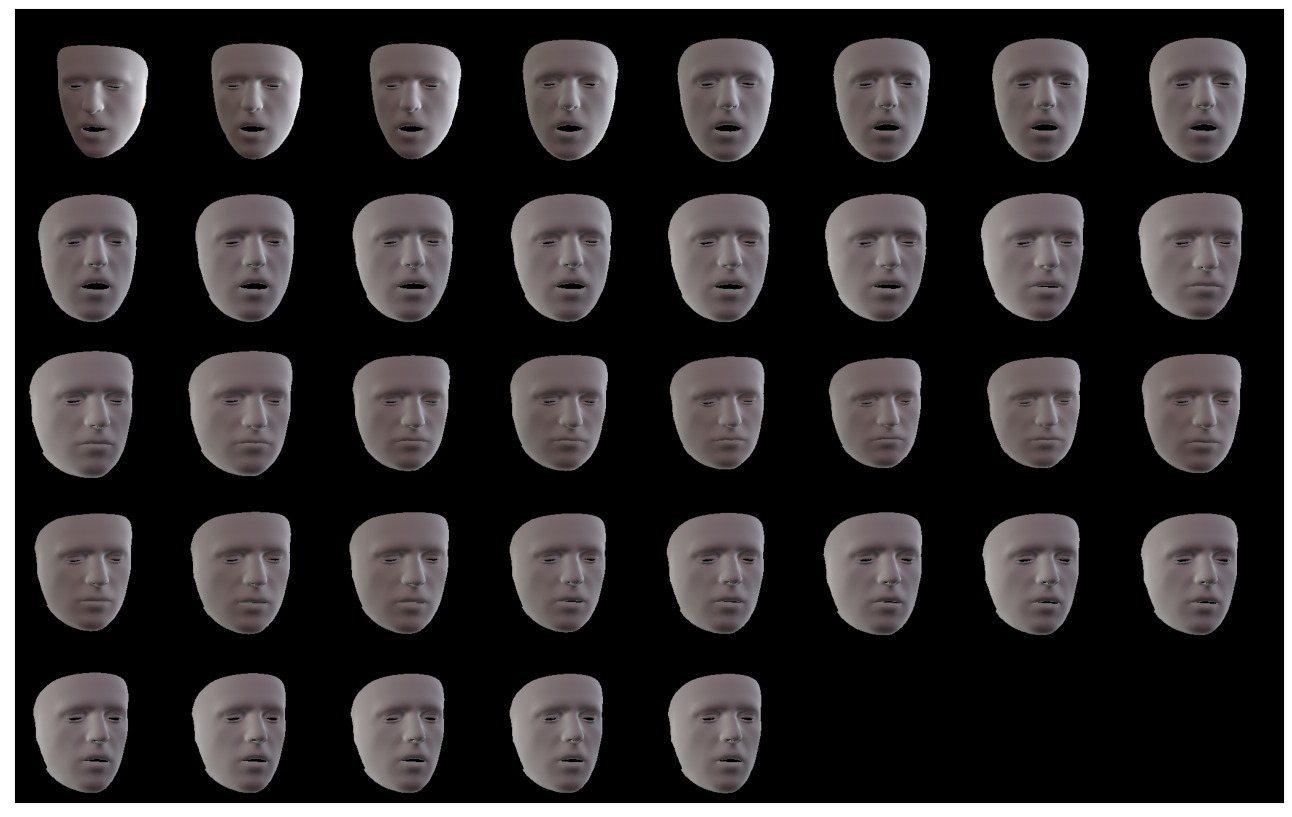

In [3]:
import numpy as np
import sys, os, glob
import blobfile as bf
from PIL import Image
import torch as th
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import tqdm


import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def save_images(images, names, save_path):
    for i, img in enumerate(images):
        save_image(img, fp=f'{save_path}/{names[i]}')
        

def load_image(path):
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    return pil_image

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/sample_utils/')
sys.path.insert(1, '/home/mint/guided-diffusion/guided_diffusion/dataloader/')

import params_utils
sj = 'tommy_2'
img_path = '/data/mint/DPM_Dataset/Videos/tommy_2/aligned_images/valid/'
#NOTE: Initialize a DECA renderer
params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'albedo', 'tform', 'detail']
deca_params, _ = params_utils.load_params(path=f'/data/mint/DPM_Dataset/Videos/{sj}/params/valid', params_key=params_key)

deca_arr = {}
frames = list(deca_params.keys())
    
mask = params_utils.load_flame_mask()
deca_obj = params_utils.init_deca(mask=mask)
for k in params_key:
        deca_arr[k] = np.stack([deca_params[f][k] for f in frames])
        # print(k, deca_arr[k].shape)
    
deca_arr['raw_image_path'] = [f'{img_path}/{f}' for f in frames]
deca_arr['raw_image'] = th.tensor(np.stack([np.array(load_image(f)).transpose(2, 0, 1) for f in deca_arr['raw_image_path']]))

deca_chunk, orig_visdict = params_utils.render_deca_videos(
                                                    deca_params=deca_arr, 
                                                    render_mode='shape', 
                                                    rotate_normals=False, 
                                                    mask=mask,
                                                    deca_obj=deca_obj)
deca_rendered = orig_visdict['shape_images']
    
os.makedirs('./with_cond_nc/', exist_ok=True)
save_images(images=deca_rendered, names=[f.split('/')[-1] for f in frames], save_path='./with_cond_nc/')
os.system(f'ffmpeg -y -start_number 16 -i ./with_cond_nc/frame%d.png -preset veryslow -c:v libx264 -crf 18 ./with_cond_nc.mp4')
grid = make_grid(deca_rendered)
show(grid)


# Render w/ create dataset

creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
shape (37, 100)
pose (37, 6)
exp (37, 50)
cam (37, 3)
light (37, 27)
albedo (37, 50)
tform (37, 9)
detail (37, 128)


  0%|          | 0/37 [00:00<?, ?it/s]/home/mint/miniconda3/envs/dpm_sampling_deca/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
100%|██████████| 37/37 [00:10<00:00,  3.52it/s]
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enabl

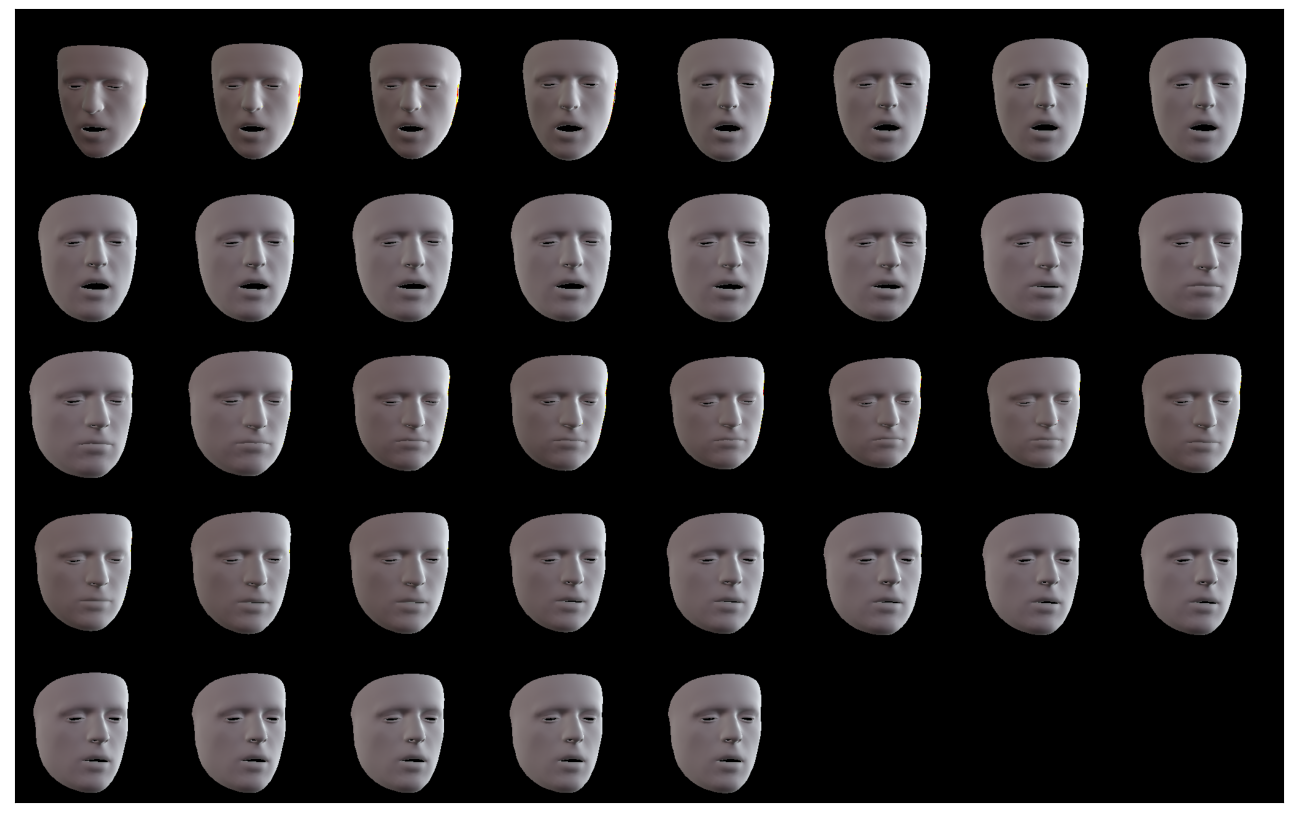

In [5]:
sys.path.insert(3, '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points
import tqdm

mask = params_utils.load_flame_mask()
device = 'cuda'

# run DECA
deca_cfg.model.use_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.extract_tex = True
deca = DECA(config = deca_cfg, device=device, mode='deca', mask=mask)

frames = deca_params.keys()
for k in params_key:
        deca_arr[k] = np.stack([deca_params[f][k] for f in frames])
        print(k, deca_arr[k].shape)
    
deca_arr = {}
deca_arr['raw_image_path'] = [f'{img_path}/{f}' for f in frames]
deca_arr['raw_image'] = th.tensor(np.stack([np.array(load_image(f)).transpose(2, 0, 1) for f in deca_arr['raw_image_path']]))

testdata = datasets.TestData(deca_arr['raw_image_path'], iscrop=True, face_detector='fan', sample_step=10)

deca_rendered = []
data_iters = range(len(testdata))
for i in tqdm.tqdm(data_iters):
    # if i == 300:
    #     break
    name = testdata[i]['imagename']
    ext = testdata[i]['imageext']
    images = testdata[i]['image'].to(device)[None,...]

    with th.no_grad():
        codedict = deca.encode(images)
        codedict.update({'name':name})
                
        tform = testdata[i]['tform'][None, ...]
        tform_inv = th.inverse(tform).transpose(1,2).to(device)
        original_image = testdata[i]['original_image'][None, ...].to(device)
        _, orig_visdict = deca.decode(codedict, render_orig=True, original_image=original_image, tform=tform_inv, use_template=False, mean_cam=None)    
        orig_visdict['inputs'] = original_image
        deca_rendered.append(orig_visdict['shape_images'])
        
        
deca_rendered = th.cat(deca_rendered, dim=0)
os.makedirs('./with_create_dat/', exist_ok=True)
save_images(images=deca_rendered, names=[f.split('/')[-1] for f in deca_arr['raw_image_path']], save_path='./with_create_dat/')
os.system(f'ffmpeg -y -start_number 16 -i ./with_create_dat/frame%d.png -preset veryslow -c:v libx264 -crf 18 ./with_create_dat.mp4')
grid = make_grid(deca_rendered)
show(grid)

In [6]:
os.system('ffmpeg -y -i ./with_cond_c.mp4 -i ./with_create_dat.mp4 -i ./with_cond_nc.mp4 -filter_complex "[0:v][1:v][2:v]hstack=3,scale=trunc(iw/2)*2:trunc(ih/2)*2,pad=width=trunc(iw/2+1)*2:height=trunc(ih/2+1)*2:x=0:y=0:color=black,format=yuv420p[v]" -map "[v]" ./cmp.mp4')

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

0